# 02450 Project 2


The primary goal of Project 2 is to apply supervised learning techniques (regression and classification) to predict properties or classifications of wood based on the cleaned and scaled dataset from Project 1.

In [196]:
import os
import numpy as np
import glob
import PIL.Image as Image
from tqdm.notebook import tqdm
import xlrd
import scipy
from scipy.linalg import svd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd


from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split


### Cleaned and Scaled Data from Project 1

In [ ]:

# Load the data
data = pd.read_csv('C:/Users/ongji/OneDrive/Documents/DTU/02450 Introduction to Machine Learning and Data Mining/02450-Project-1/usa_wood_data_formatted.csv')

# Clean data
removed_columns = ['side_hardness','tension_perpendicular_to_grain','impact_bending']
data_cleaned = data.drop(columns=removed_columns).dropna()
print(data_cleaned.head())

# Select the target variable and features
target_variable = 'specific_gravity'
X = data_cleaned.drop(columns=[target_variable])
y = data_cleaned[target_variable].values
X_num = X.iloc[:, 6:]   # numerical features

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_num, y, test_size=0.2, random_state=42)

# Scale the features
feature_scaler = StandardScaler()
X_train_scaled = feature_scaler.fit_transform(X_train)
X_test_scaled = feature_scaler.transform(X_test)

# Scale the target
target_scaler = StandardScaler()
y_train_scaled = target_scaler.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = target_scaler.transform(y_test.reshape(-1, 1))

X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train_scaled)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.FloatTensor(y_test_scaled)




In [219]:
# import pandas as pd

# # Drop columns with significant missing values
# removed_columns = ['side_hardness', 'tension_perpendicular_to_grain', 'impact_bending']
# data_cleaned = data.drop(columns=removed_columns).dropna()

# # One-hot encode categorical variables
# categorical_columns = ['classification', 'moisture_content']
# data_encoded = pd.get_dummies(data_cleaned, columns=categorical_columns)

# # Identify and remove the target attribute and other irrelevant attributes
# target_variable = 'specific_gravity'
# X = data_encoded.drop(columns=[target_variable])
# X = X.drop(columns=['common_species_name','genus','species','scientific_name'])
# y = data_encoded[target_variable].values
# #print(X.head())


# continuous_features = X.iloc[:, :6] 
# categorical_features = X.iloc[:, 6:]


# # Standardize features
# scaler = StandardScaler()
# continuous_features_scaled = scaler.fit_transform(continuous_features)
# attributeNames = X.columns

# # Combine back the scaled continuous features with the categorical
# X_scaled = np.concatenate([continuous_features_scaled, categorical_features.values], axis=1)
# attributeNames = list(continuous_features.columns) + list(categorical_features.columns)

# # Reconstruct DataFrame
# X_scaled_df = pd.DataFrame(X_scaled, columns=attributeNames)

# print("Standardized Features:")
# print(X_scaled_df.head())


In [ ]:
# Preprocessing of Data

# Drop columns with significant missing values and irrelevant columns
removed_columns = ['side_hardness', 'tension_perpendicular_to_grain', 'impact_bending','common_species_name', 'genus', 'species', 'scientific_name']
data_cleaned = data.drop(columns=removed_columns).dropna()

# one-hot encoding
categorical_columns = ['classification', 'moisture_content']
data_encoded = pd.get_dummies(data_cleaned, columns=categorical_columns)

# Target attribute
target_variable = 'specific_gravity'
X = data_encoded.drop(columns=[target_variable])
y = data_encoded[target_variable].values

# Split data into test/train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#print(X_train)

# Identify continuous and categorical features
continuous_features_train = X_train.iloc[:, :6]  
continuous_features_test = X_test.iloc[:, :6]  
categorical_features_train = X_train.iloc[:, 6:]
categorical_features_test = X_test.iloc[:, 6:]

# Scale the continuous features
scaler = StandardScaler()
continuous_features_train_scaled = scaler.fit_transform(continuous_features_train)
continuous_features_test_scaled = scaler.transform(continuous_features_test)

# Combine back scaled continuous features and categorical features
X_train_scaled = np.concatenate([continuous_features_train_scaled, categorical_features_train.values], axis=1)
X_test_scaled = np.concatenate([continuous_features_test_scaled, categorical_features_test.values], axis=1)


attributeNames = list(continuous_features_train.columns) + list(categorical_features_train.columns)
print(attributeNames)


# Scale the target
target_scaler = StandardScaler()
y_train_scaled = target_scaler.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = target_scaler.transform(y_test.reshape(-1, 1))

X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train_scaled)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.FloatTensor(y_test_scaled)


['modulus_of_rupture', 'modulus_of_elasticity', 'work_to_maximum_load', 'compression_parallel_to_grain', 'compression_perpendicular_to_grain', 'shear_parallel_to_grain', 'classification_Hardwood', 'classification_Softwood', 'moisture_content_12%', 'moisture_content_Green']


###  Two-Level Cross-Validation Model

K1 = outer loop, 
K2 = inner loop, 
h = no. of hidden neurons

Uses a cross-validation approach to find the best ANN model via finding the best h (number of hidden neurons).


In [204]:
# ANN Model

# Define variables
K1 = 10
K2 = 10

class ANN(nn.Module):
    def __init__(self, input_dim, h):
        super(ANN, self).__init__()
        self.layer1 = nn.Linear(input_dim, h)
        self.layer2 = nn.Linear(h,h)
        self.output_layer = nn.Linear(h, 1)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.output_layer(x)
        return x
    
def cross_validation(X_tensor, y_tensor, K1=10, K2=10, h_range=20):

    outer_cv = KFold(n_splits=K1, shuffle=True, random_state=42)
    inner_cv = KFold(n_splits=K2, shuffle=True, random_state=42)

    test_results =[]
    inner_errors = []

    # Outer Loop
    for i, (train_idx, test_idx) in enumerate(outer_cv.split(X_tensor)):
        X_train, X_test = X_tensor[train_idx], X_tensor[test_idx]
        y_train, y_test = y_tensor[train_idx], y_tensor[test_idx]

        best_h = None
        #best_lambda = None
        best_model = None
        lowest_error = float('inf')

        # Inner Loop
        for h in range(1, h_range + 1): # onyl try up to 20 hidden neurons
            inner_errors_for_fold = []

            for train_idx_in, val_idx in inner_cv.split(X_train):
                X_train_inner, X_val = X_train[train_idx_in], X_train[val_idx]
                y_train_inner, y_val = y_train[train_idx_in], y_train[val_idx]

                # Define model based on h  
                model = ANN(X_train_inner.shape[1], h)
                optimizer = optim.Adam(model.parameters(), lr=0.01)
                criterion = nn.MSELoss()

                # Training phase
                for epoch in range(100):
                    model.train()
                    optimizer.zero_grad()
                    outputs = model(X_train_inner)
                    loss = criterion(outputs, y_train_inner)
                    loss.backward()
                    optimizer.step()
                

                # Evaluation phase
                model.eval()
                with torch.no_grad():
                    val_outputs = model(X_val)
                    #val_loss = criterion(val_outputs, y_val)
                    val_error = mean_squared_error(y_val.numpy(), val_outputs.numpy())
                    inner_errors_for_fold.append(val_error)
                
            
            # Find best h for this fold
            avg_inner_error = np.mean(inner_errors_for_fold)
            if avg_inner_error < lowest_error: 
                lowest_error = avg_inner_error
                best_h = h
                
                    

        # Evaluate the best model based on best h
        best_model = ANN(X_train.shape[1], best_h)
        optimizer = optim.Adam(best_model.parameters(), lr=0.001)
        criterion = nn.MSELoss()
        for epoch in range(100):
            best_model.train()
            optimizer.zero_grad()
            outputs = best_model(X_train)
            loss = criterion(outputs, y_train)
            loss.backward()
            optimizer.step()

        best_model.eval()
        with torch.no_grad():
            test_outputs = best_model(X_test)
            test_error = mean_squared_error(y_test.numpy(), test_outputs.numpy())

        test_results.append((i+1, best_h, test_error))
    
    return test_results

### Results

perform cross validation on train set to determine the best h

In [221]:
results = cross_validation(X_train_tensor, y_train_tensor)
for result in results:
    print(f"Fold {result[0]} | Best h: {result[1]} | Test MSE: {result[2]:.4f}")


Fold 1 | Best h: 13 | Test MSE: 0.1232
Fold 2 | Best h: 17 | Test MSE: 0.1003
Fold 3 | Best h: 14 | Test MSE: 0.1121
Fold 4 | Best h: 17 | Test MSE: 0.2313
Fold 5 | Best h: 17 | Test MSE: 0.1919
Fold 6 | Best h: 20 | Test MSE: 0.1099
Fold 7 | Best h: 14 | Test MSE: 0.0912
Fold 8 | Best h: 17 | Test MSE: 0.1693
Fold 9 | Best h: 17 | Test MSE: 0.1826
Fold 10 | Best h: 18 | Test MSE: 0.3063


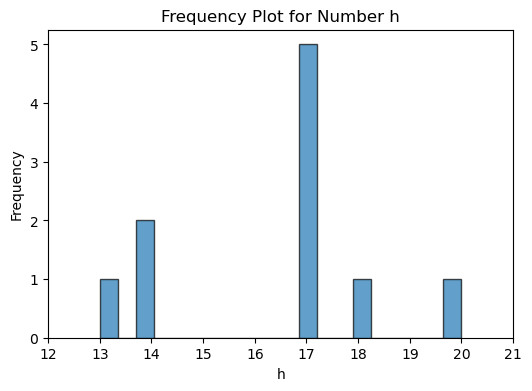

In [226]:
# Extract the h values from the results
h_values = [result[1] for result in results]


# Plot the histogram for the frequency plot of h
plt.figure(figsize=(6,4))
plt.hist(h_values, bins=20, edgecolor='black', alpha=0.7)
plt.xticks(range(int(min(h_values))-1, int(max(h_values))+2, 1))
plt.xlabel('h')
plt.ylabel('Frequency')
plt.title('Frequency Plot for Number h')
plt.show()

Train the final model using the best h on the entire training data

In [ ]:
best_h = max(set([result[1] for result in results]), key=[result[1] for result in results].count)
final_model = ANN(X_train_tensor.shape[1], best_h)
optimizer = optim.Adam(final_model.parameters(), lr=0.001)
criterion = nn.MSELoss()
 
for epoch in range(100): 
    final_model.train()
    optimizer.zero_grad()
    outputs = final_model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

# Evaluate on the test data
final_model.eval()
with torch.no_grad():
    test_outputs = final_model(X_test_tensor)
    test_error = mean_squared_error(y_test_tensor.numpy(), test_outputs.numpy())
    print(f"Test MSE: {test_error:.4f}")

Test MSE: 0.1660


Regression Plot to assess how well the model predictions match with the actual data.

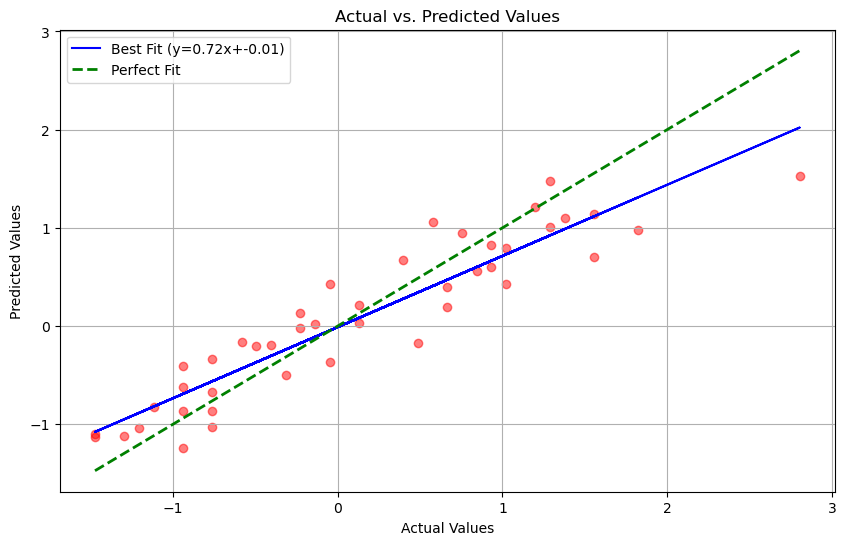

In [230]:
actual = y_test_tensor.numpy().flatten()  # Flatten to ensure it's a 1D array
predicted = test_outputs.numpy().flatten()

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(actual, predicted, alpha=0.5, color='red')
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

# Find best fit line (regression line)
m, b = np.polyfit(actual, predicted, 1)
plt.plot(actual, m*actual + b, color='blue', label=f'Best Fit (y={m:.2f}x+{b:.2f})')
plt.legend()

# Draw a line of perfect predictions
plt.plot([actual.min(), actual.max()], [actual.min(), actual.max()], 'green', lw=2, linestyle='--', label='Perfect Fit')
plt.grid(True)
plt.legend()

plt.show()